# Imports

In [1]:
# STEP 1
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Setup

In [2]:
# Setting a transformation to convert data to tensors and normalize the pixel values
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 100
# These will download the required data if the files do not exist
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Defining the samplers
dev_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(len(train_data) * dev_size))
train_idx, dev_idx = idx[split_size:], idx[:split_size]
train_sampler = SubsetRandomSampler (train_idx)
dev_sampler = SubsetRandomSampler (dev_idx)

# Defining the batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [4]:
# Creating the CNN
class CNN_network (nn.Module):
    def __init__(self):
        super(CNN_network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(4*4*40, 100)
        self.linear2 = nn.Linear(100, 10)
        
        
    def forward (self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4*4*40)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        return x

In [6]:
# Definte the model
model = CNN_network()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
episodes = 50
train_loss = []
dev_loss = []
train_accuracy = []
dev_accuracy = []
x_axis = []

# Training
for e in range(1, episodes + 1):
    loss_total = 0
    accuracy_total = 0
    iters = 0
    model.train()
    for data, target in train_loader:
        iters += 1
        pred = model(data)
        loss = loss_func(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        accuracy_total += accuracy_score(target, top_class)
        
    dev_loss_total = 0
    dev_accuracy_total = 0
    dev_iters = 0
    with torch.no_grad():
        model.eval()
        for dev_data, dev_target in dev_loader:
            dev_iters +=1
            dev_pred = model(dev_data)
            dev_l = loss_func(dev_pred, dev_target)
            dev_loss_total = dev_l.item()

            dev_p = torch.exp(dev_pred)
            top_p, dev_top_class = dev_p.topk(1, dim=1)
            dev_accuracy_total += accuracy_score(dev_target, dev_top_class)
            
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        train_loss.append(loss_total / iters)
        dev_loss.append(dev_loss_total)
        train_accuracy.append(accuracy_total / iters)
        dev_accuracy.append(dev_accuracy_total / dev_iters)

    print (f"Episode {e} / {episodes}")
    print (f"Training Loss: {(loss_total / iters)}")
    print (f"Validation Loss: {dev_loss_total}")
    print (f"Training Accuracy: {(accuracy_total / iters)}")
    print (f"Validation Accuracy: {dev_accuracy_total / dev_iters}")

Episode 1 / 50
Training Loss: 1.7402851045131684
Validation Loss: 1.3604707717895508
Training Accuracy: 0.36590000000000006
Validation Accuracy: 0.4791000000000002
Episode 2 / 50
Training Loss: 1.424523337185383
Validation Loss: 1.1915099620819092
Training Accuracy: 0.48522500000000013
Validation Accuracy: 0.5254
Episode 3 / 50
Training Loss: 1.304662015736103
Validation Loss: 1.2017862796783447
Training Accuracy: 0.5313500000000004
Validation Accuracy: 0.5695000000000001
Episode 4 / 50
Training Loss: 1.2176356586813926
Validation Loss: 1.1169852018356323
Training Accuracy: 0.5678750000000012
Validation Accuracy: 0.5982999999999999
Episode 5 / 50
Training Loss: 1.1553898631036281
Validation Loss: 1.0974631309509277
Training Accuracy: 0.5883249999999998
Validation Accuracy: 0.6166999999999998
Episode 6 / 50
Training Loss: 1.1045666687190532
Validation Loss: 0.9929322004318237
Training Accuracy: 0.6057750000000004
Validation Accuracy: 0.6203000000000001
Episode 7 / 50
Training Loss: 1.06

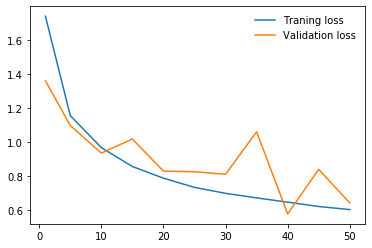

In [7]:
plt.plot(x_axis, train_loss, label = "Traning loss")
plt.plot(x_axis, dev_loss, label="Validation loss")
plt.legend(frameon=False)
plt.show()

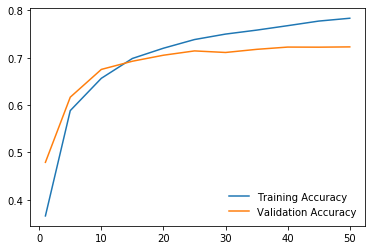

In [8]:
plt.plot(x_axis, train_accuracy, label="Training Accuracy")
plt.plot(x_axis, dev_accuracy, label="Validation Accuracy")
plt.legend(frameon=False)
plt.show()

In [9]:
iters_test = 0
test_accuracy = 0
model.eval()
for test_data, test_target in test_loader:
    iters_test +=1
    test_pred = model(test_data)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    test_accuracy += accuracy_score(test_target, top_class_test)
print (test_accuracy / iters_test)

0.7185000000000001
